In [1]:
import torch
import torchaudio # Also requires torchcodec and ffmpeg on your system

from basic_pitch.inference import predict, Model
from basic_pitch import ICASSP_2022_MODEL_PATH

from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.transforms import Fade

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Get demucs
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
model.to(device)
sample_rate = bundle.sample_rate

print(f"Sample rate: {sample_rate}Hz")

Sample rate: 44100Hz


In [3]:
# Inspired by pytorch tutorial https://docs.pytorch.org/audio/2.4.0/tutorials/hybrid_demucs_tutorial.html
def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final


def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    _, axs = plt.subplots(1, 2)
    i = 0
    for ax in axs:
        ax.imshow(spectrogram[i], cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
        ax.set_title(title + ' ' + ('left' if i == 0 else 'right'))
        i += 1
    plt.tight_layout()


In [5]:
song_path = 'data/rock.wav'
waveform, sample_rate = torchaudio.load(song_path)
waveform = waveform.to(device)
mixture = waveform

# parameters
segment = 10
overlap = 0.1

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()  # normalization

sources = separate_sources(
    model,
    waveform[None],
    device=device,
    segment=segment,
    overlap=overlap,
)[0]
sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

In [6]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

KeyboardInterrupt: 

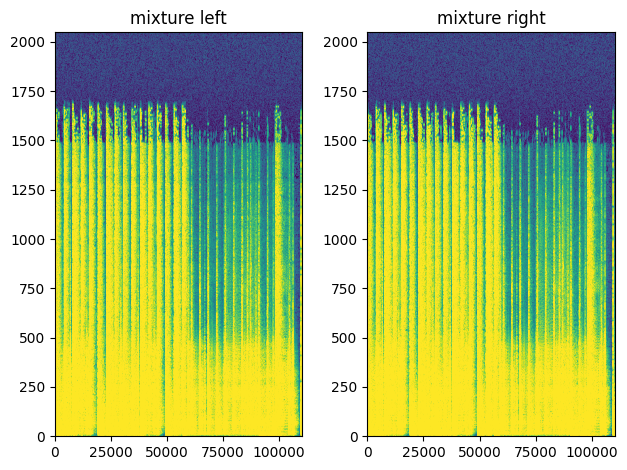

In [7]:
start = 60*sample_rate
end = 70*sample_rate

plot_spectrogram(stft(mixture[:, start:end].cpu()), "mixture")
for source in sources_list:
    plot_spectrogram(stft(audios[source][:, start:end].cpu()), source)

In [9]:
source_paths = {}
for source in sources_list:
    path = f'output/{source}.wav'
    torchaudio.save(path, audios[source].cpu(), sample_rate)
    print(f"Saved {path}")
    source_paths[source] = path

Saved output/drums.wav
Saved output/bass.wav
Saved output/other.wav
Saved output/vocals.wav


In [10]:
basic_pitch_model = Model(ICASSP_2022_MODEL_PATH)

for source in source_paths:
    model_output, midi_data, note_events = predict(source_paths[source], basic_pitch_model)
    midi_data.write(f'output/{source}.mid')

Predicting MIDI for output/drums.wav...
Predicting MIDI for output/bass.wav...
Predicting MIDI for output/other.wav...
Predicting MIDI for output/vocals.wav...
